##  **Análise de eventos astronômicos no dataset da NASA**

*Uma análise para descobrir o bólido de maior energia radiada no dataset da NASA*

## 1\. Importação das Bibliotecas

Nesta sessão fazemos a importação de todas as bibliotecas que iremos precisar

In [1]:
import pandas as pd
import calendar 
import folium
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

url = "https://data.nasa.gov/resource/mc52-syum.json"

df = pd.read_json(url)

## 2\. Análise Exploratória

Aqui começamos a nos familiarizar com os nossos dados

In [2]:
# Apresenta a "cabeça do DataFrame"
df.head(3)

,date_time_peak_brightness_ut,latitude_deg,longitude_deg,altitude_km,velocity_km_s,velocity_components_km_s_vx,velocity_components_km_s_vy,velocity_components_km_s_vz,total_radiated_energy_j,calculated_total_impact_energy_kt
0,2009-11-21T20:53:00.000,22.0S,29.2E,38.0,32.1,3.0,-17.0,-27.0,10000000000000,18.00
1,2015-01-09T10:41:11.000,2.0N,28.8E,36.0,NaN,-10.7,-7.6,11.6,139000000000,0.41
2,2014-05-16T12:42:48.000,44.2S,176.2W,44.0,NaN,14.4,4.6,6.5,309000000000,0.82


In [3]:
# Apresente as dimensões do DataFrame
df.shape

(92, 10)

## 3\. Tratamento dos Dados

### 3.1 Decompondo a coluna data e hora e excluindo as colunas desnecessárias

Mais a frente vamos precisar da coluna 'data' separada da informação das 'horas', vamos separá-las

In [4]:
# Desmenbra a coluna 'date_time_peak_brightness_ut' em outras duas com a data e a hora do registro
df['date'] = pd.to_datetime(df['date_time_peak_brightness_ut']).dt.date
df['time'] = pd.to_datetime(df['date_time_peak_brightness_ut']).dt.time

# Exclui as colunas desnescessárias do nossao df
df.drop(columns=['date_time_peak_brightness_ut',  
                 'altitude_km', 
                 'velocity_km_s', 
                 'velocity_components_km_s_vx', 
                 'velocity_components_km_s_vy', 
                 'velocity_components_km_s_vz'], inplace=True)

# Apresenta as primeiras linhas da nova tabela
df.head(3)

,latitude_deg,longitude_deg,total_radiated_energy_j,calculated_total_impact_energy_kt,date,time
0,22.0S,29.2E,10000000000000,18.00,2009-11-21,20:53:00
1,2.0N,28.8E,139000000000,0.41,2015-01-09,10:41:11
2,44.2S,176.2W,309000000000,0.82,2014-05-16,12:42:48


### 3.2 Tratando as Variáveis da longitude e latitude da notação em graus para float

A biblioteca "Folium" precisa que as coordenadas de geolocalização estajam no formato float, a nossa base traz essa informação em graus, precisamos alterá-la

In [5]:
# Função para converter latitude de graus para float
def converter_latitude(latitude_str):
    latitude_str = latitude_str.replace('N', '').replace('S', '')
    return float(latitude_str)

# Função para converter longitude de graus para float
def converter_longitude(longitude_str):
    longitude_str = longitude_str.replace('E', '').replace('W', '')
    return float(longitude_str)

# Aplicar as funções às colunas do DataFrame
df['latitude_deg'] = df['latitude_deg'].apply(converter_latitude)
df['longitude_deg'] = df['longitude_deg'].apply(converter_longitude)

In [6]:
# Mostra as novas dimensões do nosso DataFrame
df.shape

(92, 6)

In [7]:
# Apresenta o formato dos dados que o pandas reconheceu
df.dtypes

latitude_deg                         float64
longitude_deg                        float64
total_radiated_energy_j                int64
calculated_total_impact_energy_kt    float64
date                                  object
time                                  object
dtype: object

In [8]:
#confirma se nenhuma coluna apresenta dados faltantes (False quer dizer que não)
df.isna().any()

latitude_deg                         False
longitude_deg                        False
total_radiated_energy_j              False
calculated_total_impact_energy_kt    False
date                                 False
time                                 False
dtype: bool

In [9]:
# cria uma nova coluna com os dados reduzidos proporcionalmente para a escala de 1e14 (notação científica 10^14)
df['total_radiated_energy_1e14j'] = df['total_radiated_energy_j'] / 100000000000000

In [10]:
#Confere qual é o maior valor da coluna
print(f"{df['total_radiated_energy_1e14j'].max() } x 1e14 Joules")

3.75 x 1e14 Joules


## 4\. Visualização dos Dados

Definição da função que monta o gráfico, vamos querer visualizar mais de uma vez, criar uma função evita redundância no código

In [11]:
# Define a função que será usada para criar o gráfico de barras
def bar_chart_plot(df: pd.DataFrame, title: str, size: int) -> None: 
    # Plot com Seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='date', y='total_radiated_energy_1e14j', data=df)
    ax.set(title=title, xlabel='Data', ylabel='Energia Irradiada (x1e14 Joules)')

    plt.xticks(rotation=90)
    ax.set_xticklabels(ax.get_xticklabels(), size=size)
    plt.tight_layout()
    plt.show()

Criamos nosso primeiro gráfico, logo podemos notar um evento que se destaca absurdamente dos demais

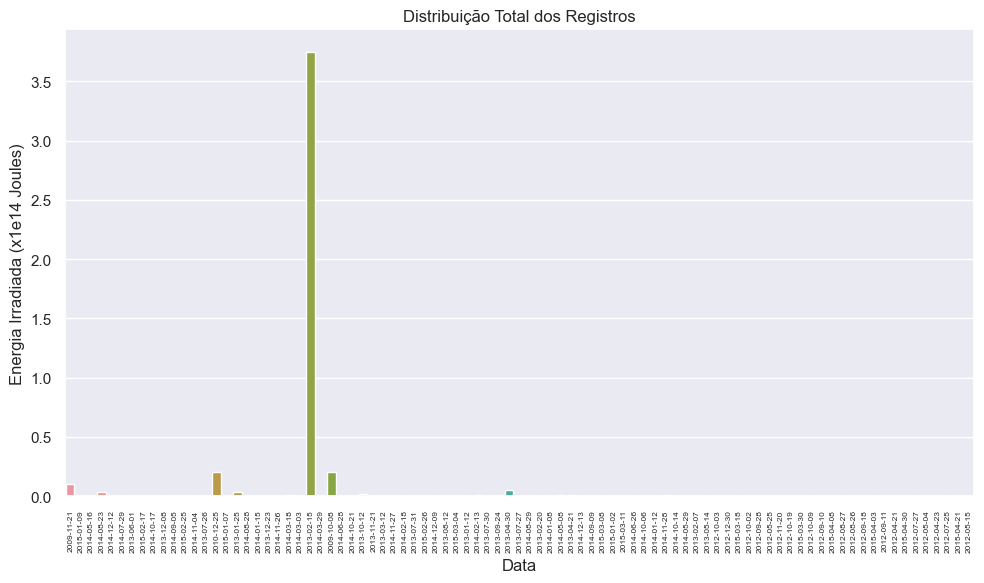

In [12]:
# faz a chamada da função passando comop parâmetro o DataFrame
bar_chart_plot(df, 'Distribuição Total dos Registros', 6)

Ordenamos os dados para rankear os 10 maiores eventos e mesmo assim a discrepância do 1° para o 2° é absurda 

In [13]:
# Filtra e ordena o DataFrame resultando os 10 maiores valores da coluna
df_ordenado = df.sort_values(by='total_radiated_energy_j', ascending=False)
df_ordenado = df_ordenado.head(10)

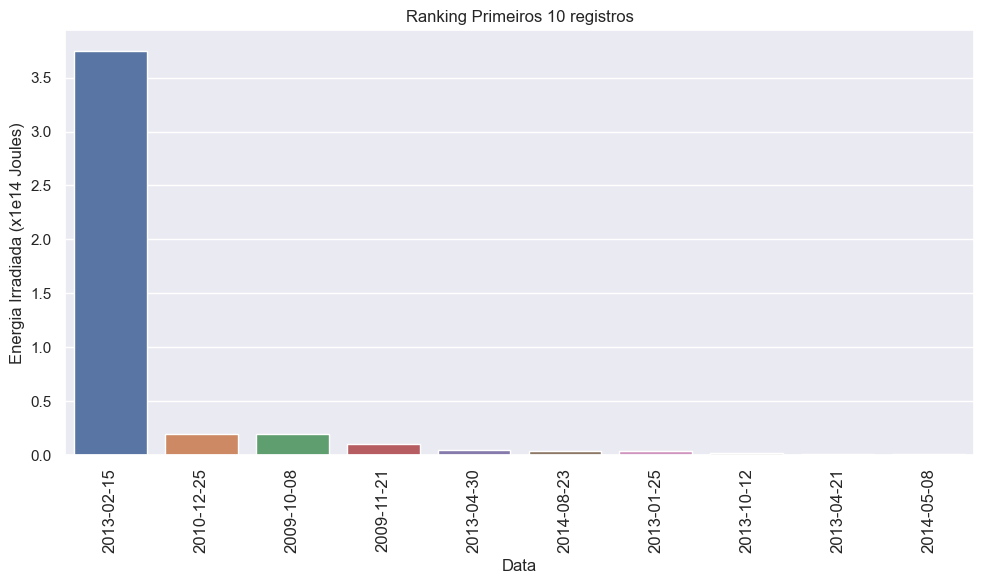

In [14]:
# Faz mais uma chamada passando como parâmetro o novo DataFrame filtrado
bar_chart_plot(df_ordenado, 'Ranking Primeiros 10 registros', 12)

Analisando melhor a cronologia dos eventos, "BINGO" um evento extremamente potente se destaca, e sua energia medida em kilotons é enorme

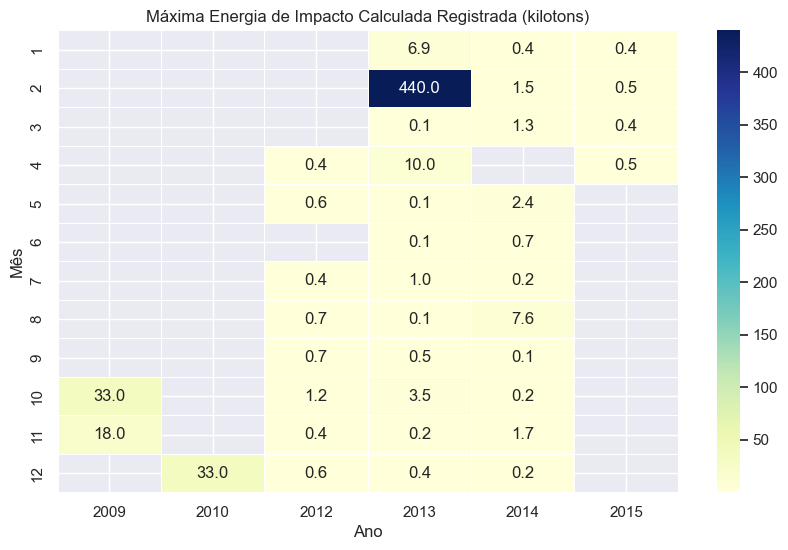

In [15]:
# Converter a coluna 'date' para o tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Extrair o mês e o ano em colunas separadas
df['ano'] = df['date'].dt.year
df['mes'] = df['date'].dt.month

# Criar uma tabela pivot para o heatmap
heatmap_data = df.pivot_table(values='calculated_total_impact_energy_kt', index='mes', columns='ano', aggfunc='max')

# Criar o heatmap usando o Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=0.5, cbar=True)
plt.title('Máxima Energia de Impacto Calculada Registrada (kilotons)')
plt.xlabel('Ano')
plt.ylabel('Mês')

plt.show()

## 5\. Geolocalização das Coordenadas

Contamos nesse DataFrame com dados de geolocalização e com a biblioteca Folium fica fácil localizar os eventos

In [16]:
mapa = folium.Map(location=[54.8, 61.1], zoom_start=3)

for energia, la, lo in zip(df['total_radiated_energy_1e14j'], df['latitude_deg'] , df['longitude_deg']):
	folium.Marker([la, lo], tooltip=f"Energia Irradiada: {energia} x 1e14 Joules").add_to(mapa)

mapa

## 6\. Resumo e insight gerados

Partimos de um endereço de uma *URL* que nos dá acesso aos dados no formato **JSON** de vários registros de eventos astronômicos em um entervalo de tempo, esses registros contam com informação de data, energia irradiada em Joules, informação de geolocalização do evento, além de dados de energia de impacto calculada, carregamos, analizamos e limpamos esses dados a fim de extrair informações relevantes dessa massa de dados. Logo no inicio mesmo em um simples gráfico de barras percebemos um evento que se destaca de maneira impar em nosso DataFrame, esse evento, fica evidente ser muitas vezes maior do que o segundo o que nos traz uma certeza de que algo fora do comum aconteceu. 
Isolando esse evento, nos aprofundando mais nas informações apresentadas, temos que o evento ocorreu no dia *15/02/2013* no território da Russia, uma breve consulta por esta data segudo por "Russia" no buscador e é fácil encontrar o evento ocorrido em **Chelyabinsk**, foi algo que assustou o mundo.
<br/>
<br/>
<br/>
<br/>
<img 
    style="width:100%" src="https://imgs.search.brave.com/avkBuBH3g_K1rbwyZ5hB_yQH9IpnzWTIcDr09_MWROw/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9jMDIu/cHVycGxlZHNodWIu/Y29tL3VwbG9hZHMv/c2l0ZXMvNDgvMjAx/OS8wMy9DaGVseWFi/aW5zay1maXJlYmFs/bC1kYXNoY2FtLWJl/c3QtMTM5MTkzNi5q/cGc">
<br/>
<br/>
<br/>
<br/>
Esse evento foi registrado de vários angulos diferentes, sua tragetória passa exatamente sobre o ponto que encontramos em nosso DataFrame
<br/>
<br/>
<br/>
<br/>
<img 
    style="width:100%" 
    src="https://imgs.search.brave.com/gvGi50nxAo24fWY4lvw_HeRL3X8_sKir3H3by-GySqo/rs:fit:860:0:0/g:ce/aHR0cHM6Ly91cGxv/YWQud2lraW1lZGlh/Lm9yZy93aWtpcGVk/aWEvY29tbW9ucy8w/LzAyL1RyYWplY3Rv/cnlfb2ZfQ2hlbHlh/Ymluc2tfbWV0ZW9y/b2lkX2VuLnBuZw"
    >
<br/>
<br/>
<br/>
<br/>